# Import all libraries

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.python.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import argparse
import random
import pickle
import cv2
import sys
import os

# Use arguments to retrieve the dataset directories, and the output files
### Change the path to the different args in the variables
### --train_dataset (train_dataset): train dataset subdirectory
### --test_dataset (test_dataset): test dataset subdirectory
### --val_dataset (val_dataset): validation dataset subdirectory

### --model (model_output): model file generated
### --label-bin (pickle_output): pickle file generated
### --plot (plot_output): accuracy and loss graphics generated
### --matrix (matrix_output): confusion matrix generated

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\")

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
session = tf.compat.v1.Session(config=config)

train_dataset = "chest_Xray/train"
test_dataset = "chest_Xray/test"
val_dataset = "chest_Xray/val"
model_output = "output/zoidberg.model"
pickle_output = "output/zoidberg.pickle"
plot_output = "output/zoidberg_plot.png"
matrix_output = "output/zoidberg_matrix.png"

ap = argparse.ArgumentParser()
ap.add_argument("-tr", "--train_dataset", required=True,
                help="path to train input dataset of images")
ap.add_argument("-te", "--test_dataset", required=True,
                help="path to test input dataset of images")
ap.add_argument("-v", "--val_dataset", required=True,
                help="path to val input dataset of images")
ap.add_argument("-m", "--model", required=True,
                help="path to output trained model")
ap.add_argument("-l", "--label-bin", required=True,
                help="path to output label binarizer")
ap.add_argument("-p", "--plot", required=True,
                help="path to output accuracy/loss plot")
ap.add_argument("-x", "--matrix", required=True,
                help="path to output confusion matrix")
args = vars(ap.parse_args(
    [
        "--train_dataset", train_dataset,
        "--test_dataset", test_dataset,
        "--val_dataset", val_dataset,
        "--model", model_output,
        "--label-bin", pickle_output,
        "--plot", plot_output,
        "--matrix", matrix_output
    ]))

classes = ["BACTERIA", "NORMAL", "VIRUS"]
img_size = 64

# Parse dataset, resize and push images to np.array

In [3]:
def get_data(data_dir):
    data = []
    for class_label in classes:
        path = os.path.join(data_dir, class_label)
        class_num = classes.index(class_label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


train = get_data(args["train_dataset"])
val = get_data(args["test_dataset"])
print(train[0])

'NoneType' object is not subscriptable


<ipython-input-3-1913a5791abd>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


[array([[[24, 24, 24],
        [35, 35, 35],
        [47, 47, 47],
        ...,
        [27, 27, 27],
        [20, 20, 20],
        [ 7,  7,  7]],

       [[24, 24, 24],
        [40, 40, 40],
        [46, 46, 46],
        ...,
        [30, 30, 30],
        [21, 21, 21],
        [ 6,  6,  6]],

       [[34, 34, 34],
        [44, 44, 44],
        [45, 45, 45],
        ...,
        [31, 31, 31],
        [19, 19, 19],
        [11, 11, 11]],

       ...,

       [[11, 11, 11],
        [ 5,  5,  5],
        [ 0,  0,  0],
        ...,
        [14, 14, 14],
        [16, 16, 16],
        [16, 16, 16]],

       [[10, 10, 10],
        [ 5,  5,  5],
        [ 0,  0,  0],
        ...,
        [14, 14, 14],
        [15, 15, 15],
        [16, 16, 16]],

       [[10, 10, 10],
        [ 5,  5,  5],
        [ 0,  0,  0],
        ...,
        [14, 14, 14],
        [15, 15, 15],
        [15, 15, 15]]], dtype=uint8)
 0]


# Create label array based on the dataset folder structure

c:\users\johan\documents\repos\esp_700\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


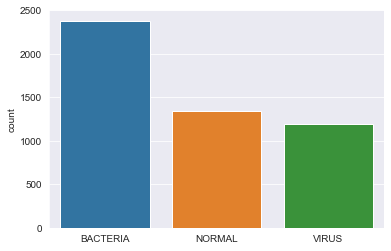

In [4]:
l = []
for i in train:
    if i[1] == 0:
        l.append("BACTERIA")
    elif i[1] == 1:
        l.append("NORMAL")
    elif i[1] == 2:
        l.append("VIRUS")

sns.set_style("darkgrid")
sns.countplot(l)

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

# Split the training dataset

In [5]:
(trainX, testX, trainY, testY) = train_test_split(x_train,
                                                  y_train, test_size=0.2, random_state=10)

# Transform label into vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Data augmentation process on the dataset
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="nearest")

datagen.fit(trainX)

# Create the artificial neural network model with multiple layers

In [6]:
class ZoidbergModel:

    @staticmethod
    def build(width, height, depth):

        input_shape = (height, width, depth)

        _model = Sequential()
        _model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=input_shape))
        _model.add(MaxPool2D())

        _model.add(Conv2D(32, 3, padding="same", activation="relu"))
        _model.add(MaxPool2D())

        _model.add(Conv2D(64, 3, padding="same", activation="relu"))
        _model.add(MaxPool2D())
        _model.add(Dropout(0.25))

        _model.add(Flatten())
        _model.add(Dense(128, activation="relu"))
        _model.add(Dense(3, activation="softmax"))

        _model.summary()

        return _model


# Build model based on the training parameters

In [7]:
model = ZoidbergModel.build(width=img_size, height=img_size, depth=len(classes))

# Adam optimizer with the Learning Rate as parameter
opt = Adam(lr=0.00001)
# Compiling the model with categorical crossentropy while measuring accuracy
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# Runs through the complete dataset
EPOCHS = 500
# Treated images before updating the model
BS = 500
# Preventing overfitting by monitoring the "val_loss" metric for a number of EPOCHS (patience)
ES = EarlyStopping(monitor="val_loss", patience=10)
H = model.fit(trainX, trainY, epochs=EPOCHS,
              validation_data=(testX, testY), validation_split=0.3, batch_size=BS, callbacks=ES)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

In [8]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(EPOCHS)


# Run predictions on the testing dataset

In [9]:
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1, -1)[0]
print(classification_report(y_val, predictions,
                            target_names=["BACTERIA", "NORMAL", "VIRUS"]))

              precision    recall  f1-score   support

    BACTERIA       0.71      0.98      0.82       242
      NORMAL       0.94      0.51      0.66       234
       VIRUS       0.64      0.71      0.68       140

    accuracy                           0.74       616
   macro avg       0.77      0.74      0.72       616
weighted avg       0.78      0.74      0.73       616



# Generating Accuracy & Loss plots

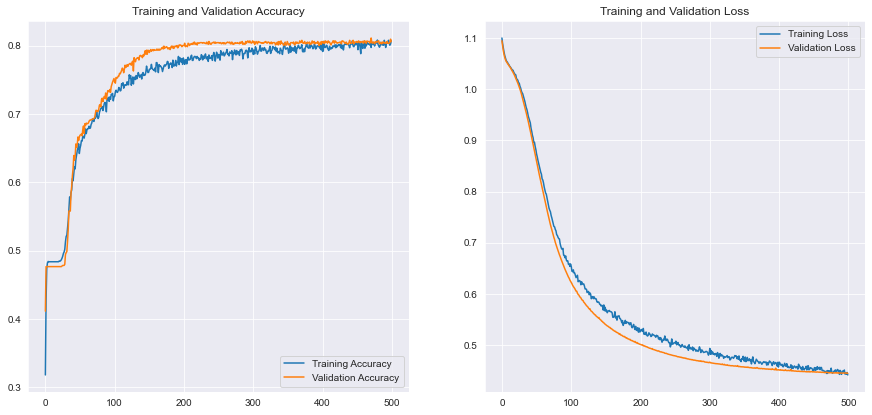

In [10]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(args["plot"])


# Generating Confusion Matrix

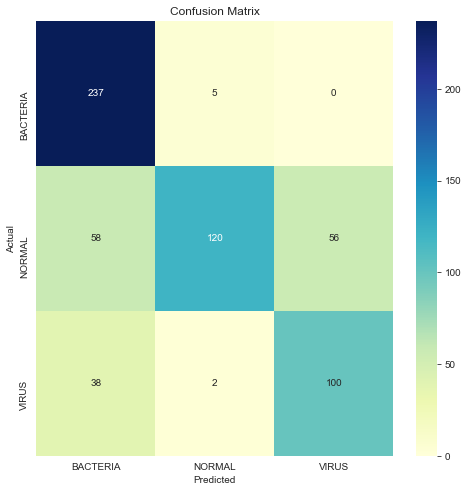

In [11]:
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(8, 8))
plt.title("Confusion Matrix")
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(args["matrix"])

In [12]:
model.save(args["model"], save_format="h5")
f = open(args["label_bin"], "wb")
f.write(pickle.dumps(lb))
f.close()

# Run prediction with trained model

Text(0.5, 1.0, 'Prediction : NORMAL: 99.21%')

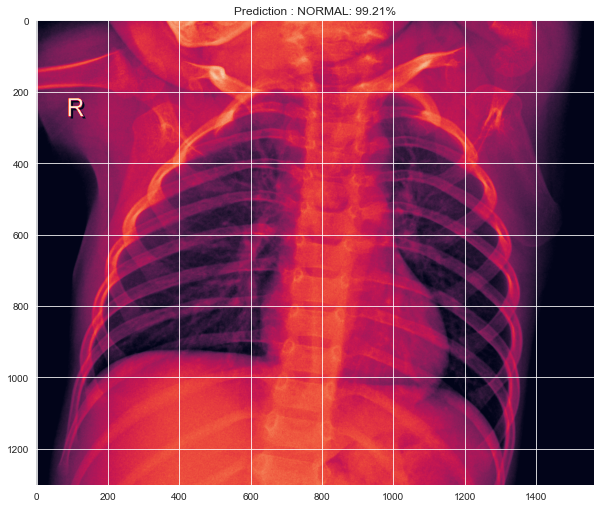

In [13]:
imagelist = [os.path.join(r, file) for r, d, f in os.walk(args["val_dataset"]) for file in f]
random.shuffle(imagelist)

imageselected = imagelist[0]
image = cv2.imread(imagelist[0])
output = image.copy()
image = cv2.resize(image, (img_size, img_size))

image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

model = load_model(args["model"])
lb = pickle.loads(open(args["label_bin"], "rb").read())

predicted = model.predict(image)
i = predicted.argmax(axis=1)[0]
label = lb.classes_[i]
label_predicted = ""

if label == 0:
    label_predicted = "BACTERIA"
elif label == 1:
    label_predicted = "NORMAL"
elif label == 2:
    label_predicted = "VIRUS"

plt.figure(figsize=(10, 10))
img = Image.open(imageselected, "r")
plt.imshow(np.asarray(img))
plt.title("Prediction : " + "{}: {:.2f}%".format(label_predicted, predicted[0][i] * 100))